<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/09_TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de un modelo LSTM

#### **Importación de Datos**

In [1]:
!pip install pytorch-forecasting==1.4.0 pytorch-lightning==2.4.0 torchmetrics==1.3.1 ucimlrepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 68.3 MB/s eta 0:00:00


In [2]:
import requests
import pandas as pd
import numpy as np
import sys, os, math, typing as t
import warnings

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import pytorch_lightning as pl

from datetime import timedelta
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import LightningModule

from io import BytesIO
from dataclasses import dataclass


In [3]:
plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True
})

warnings.filterwarnings('ignore')

In [ ]:
# 1. Carga y preparación inicial del dataset

# URL del dataset enriquecido (Zone_1 ya filtrada y con variables climáticas añadidas).
# Este archivo contiene el consumo eléctrico de la zona 1 de Tetuán (2017),
# con resolución temporal de 10 minutos y variables exógenas (clima).
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/enriched_zone1_power_consumption_of_tetouan_city.csv'

# Descargar el archivo directamente desde GitHub.
# Esto asegura reproducibilidad: siempre usaremos la misma fuente en la nube,
# sin depender de archivos locales.
response = requests.get(DATA_GITHUB_URL)

# Convertir el archivo descargado en un DataFrame de Pandas.
# Notar que el dataset ya está en CSV.
df = pd.read_csv(BytesIO(response.content), sep=',')

# Convertir la columna datetime a tipo fecha-hora.
# Esto es clave para mantener la resolución de 10 minutos y
# habilitar operaciones temporales (lags, resample, features de calendario).
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Antes indexábamos directamente con datetime, pero ahora no es necesario
# porque PyTorch Forecasting/TFT usa un índice temporal entero (time_idx).
# df = df.set_index("datetime")

# Crear columna 'time_idx': índice entero incremental cada 10 minutos.
# Es requerido por TimeSeriesDataSet (TFT) para ordenar secuencias en el tiempo.
t0 = df["datetime"].min()
df["time_idx"] = ((df["datetime"] - t0) / pd.Timedelta(minutes=10)).astype(int)

# Validación de columnas mínimas.
# Nos aseguramos de que el dataset tenga las variables clave:
#  - zone_1: serie objetivo (target).
#  - temperature, humidity, general_diffuse_flows: covariables climáticas relevantes.
expected_cols = {"temperature","humidity","general_diffuse_flows","zone_1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el dataset: {missing}. "
                    f"Columnas disponibles: {df.columns.tolist()}")

# Features de calendario: día de la semana (0=Lunes,...,6=Domingo).
# Este tipo de variables ayudan al TFT a capturar patrones estacionales/semana laboral,
# que en consumo energético suelen ser muy marcados (ej: más consumo en lunes-viernes).
df["day_of_week"] = df["datetime"].dt.dayofweek

# Visualización rápida de las primeras filas del DataFrame.
print(df.head())

             datetime  temperature  humidity  wind_speed  \
0 2017-01-01 00:00:00        6.559      73.8       0.083   
1 2017-01-01 00:10:00        6.414      74.5       0.083   
2 2017-01-01 00:20:00        6.313      74.5       0.080   
3 2017-01-01 00:30:00        6.121      75.0       0.083   
4 2017-01-01 00:40:00        5.921      75.7       0.081   

   general_diffuse_flows       zone_1  is_weekend  is_holiday  hour  day  \
0                  0.051  34055.69620        True        True     0    1   
1                  0.070  29814.68354        True        True     0    1   
2                  0.062  29128.10127        True        True     0    1   
3                  0.091  28228.86076        True        True     0    1   
4                  0.048  27335.69620        True        True     0    1   

   month  time_idx  day_of_week  
0      1         0            6  
1      1         1            6  
2      1         2            6  
3      1         3            6  
4      1    

#### **Definición de Funciones y Partición de los datos**

In [ ]:
# 2) Definición de horizontes y ventana histórica

# Horizonte de predicción: 24 horas a resolución de 10 minutos.
# 24 h * 6 (intervalos de 10 min por hora) = 144 pasos. Esto permite
# decisiones operativas de corto plazo (despacho / sobrecarga).
prediction_length = 24 * 6        # 24 horas * 6 (10-min steps) = 144

# Ventana histórica del encoder: ~7 días (1.008 pasos). Esto expone al TFT
# ciclos diarios y semanales, y suficiente estructura para que el mecanismo
# de atención capte patrones recurrentes.
# Nota: si tu GPU/RAM se queda corta, reduce gradualmente (p.ej. a 3-5 días).
max_encoder_length = 7 * 24 * 6   # 7 días históricos (~1008) — ajustar si memoria se agota


# 3) Identificador de serie
# En este experimento trabajamos solo con Zone_1. El TFT requiere un ID de grupo
# (útil cuando hay múltiples series). Aquí lo fijamos constante ('zone_1') para
# mantener la API consistente y permitir normalización por-grupo.
df['zone'] = 'zone_1'

# 4) Corte temporal train/val

# Usamos un hold-out temporal: todo lo que quede ANTES de las últimas 24h
# se va a training; las últimas 24h quedan para validación/predicción.
# Esto evita "fugas de tiempo" y replica el escenario real (predecir el futuro).
training_cutoff = df['time_idx'].max() - prediction_length

training = TimeSeriesDataSet(
    # Filtramos hasta el corte: solo pasado para entrenar
    df[df.time_idx <= training_cutoff],
    
    # === Campos obligatorios para TFT ===
    time_idx="time_idx",          # índice temporal entero (10-min steps)
    target="zone_1",              # variable objetivo: consumo en Zone_1
    group_ids=["zone"],           # ID de serie (constante aquí ya que sólo trabajamos con la zona 1)

    # === Longitudes encoder/decoder ===
    # Permitimos cierta variación en el encoder (mitad hasta el máximo) para robustez.
    min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    # En el decoder (predicción) dejamos de 1 hasta el horizonte completo (144).
    min_prediction_length=1,
    max_prediction_length=prediction_length,

    # === Esquema de variables ===
    # Variable estática categórica por serie. Aunque hay una sola zona,
    # esto permite que el normalizador "por grupo" funcione y sería escalable
    # si luego agregas zone_2/zone_3.
    static_categoricals=["zone"], #Es una sola zona, la zona 1.
    time_varying_known_reals=["time_idx", "hour", "day", "day_of_week", "month", "is_weekend", "is_holiday", "temperature", "humidity", "wind_speed", "general_diffuse_flows"],
    
    # Variables reales cuyo FUTURO no es conocido a priori y que el modelo debe
    # predecir o usar solo hasta "ahora". Siempre incluye el target.
    time_varying_unknown_reals=["zone_1"],

    # Normalización por grupo (aquí el grupo es "zone").
    # Esto centra/escala la serie objetivo por zona, evitando sesgos por escala.
    target_normalizer=GroupNormalizer(groups=["zone"]),

    # === Features automáticas útiles para TFT ===
    add_relative_time_idx=True,   # índice relativo dentro de cada ventana
    add_target_scales=True,       # guarda media/desv. del target por serie
    add_encoder_length=True,      # longitud efectiva del encoder (útil si varía)
)

# 6) Conjunto de validación
# Reutiliza el esquema/normalizadores del training y define la partición de validación
# en la "cola" de la serie (últimas 24h). stop_randomization=True asegura que
# no se permute el corte (reproducibilidad).
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# 7) DataLoaders
# Batch moderado para estabilidad. Si usas GPU, num_workers=4 suele ir bien.
# Puedes ajustar batch_size según VRAM. En validación, usar batch mayor acelera.
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=64*4, num_workers=4)

#### **Entrenamiento**

In [ ]:
# 8) LigthningModule wrapper para el TFT
#    - Centraliza ciclo de entrenamiento/validación en PL
#    - Reutiliza la loss del propio TFT (p.ej., QuantileLoss)
#    - Delegamos el optimizador al TFT para mantener consistencia

class TFTLightningWrapper(LightningModule):
    def __init__(self, tft):
        super().__init__()
        self.tft = tft                # Modelo TFT ya instanciado (de PyTorch Forecasting)
        self.loss = tft.loss          # Usamos la misma función de pérdida del TFT (ej. QuantileLoss)
        # Guardamos hiperparámetros del wrapper (útil para reproducibilidad y logs),
        # ignorando objetos no serializables (el modelo y la loss como instancias).
        self.save_hyperparameters(ignore=["tft","loss"])

    def forward(self, x):
        # Paso "forward" delega completamente en el TFT.
        # En PF, el forward suele devolver un tensor con shape:
        # [batch_size, prediction_length, n_targets * n_quantiles] (si es cuantílico)
        # o [batch_size, prediction_length, n_targets] (si es MSE).
        return self.tft(x)

    def training_step(self, batch, batch_idx):
        # batch = (x, y) tal como lo producen los DataLoaders del TimeSeriesDataSet.
        # x: dict/tensor con entradas del encoder/decoder
        # y: target real con shape [batch_size, prediction_length]
        x, y = batch
        out = self(x)                 # Predicción del TFT para la ventana del decoder
        loss = self.loss(out[0], y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Mismo patrón para validación: no hay gradientes, pero calculamos y registramos pérdida.
        x, y = batch
        out = self(x)
        loss = self.loss(out[0], y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # Delegamos la creación de optimizadores/esquemas de LR al propio TFT,
        # que ya sabe qué parámetros y LR-scheduler usar según su configuración.
        return self.tft.configure_optimizers()

In [ ]:
# 9) Callbacks y Trainer de PyTorch Lightning
#    - EarlyStopping: frena si no mejora val_loss
#    - Checkpoint: guarda el mejor modelo (val_loss mínima)
#    - LR Monitor: registra evolución del learning rate
#    - CheckDevice: confirma si se estamos entrenando en GPU/CPU

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, Callback

class CheckDeviceCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        # Útil para confirmar que realmente estamos usando CUDA si está disponible.
        print(f"\nEntrenando en dispositivo: {next(pl_module.parameters()).device}\n")

# EarlyStopping:
#  - monitor: métrica a vigilar (aquí val_loss, que ya registramos en validation_step)
#  - patience=5: si 5 épocas seguidas no mejora, se detiene (bueno para evitar sobreentrenar)
early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")

# ModelCheckpoint:
#  - guarda el mejor checkpoint según val_loss
#  - save_top_k=1: solo el mejor
#  - filename incluye epoch y val_loss para identificar fácilmente
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="tft-{epoch:02d}-{val_loss:.4f}")

# Monitoreo del LR (útil si luego usamos schedulers)
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Trainer:
#  - max_epochs=30: debería ser suficiente para converger en este caso; ajusta según curvas
#  - accelerator: GPU si hay CUDA, de lo contrario CPU
#  - gradient_clip_val=0.1: muy importante en TFT para estabilizar entrenamiento
#  - log_every_n_steps: frecuencia de logging
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None, # en CPU, Lightning ignora 'devices' si es None
    callbacks=[early_stop, checkpoint, lr_monitor, CheckDeviceCallback()],
    gradient_clip_val=0.1,
    log_every_n_steps=10
)

# 10) Instanciación del Temporal Fusion Transformer
#    - from_dataset hereda metadatos del TimeSeriesDataSet (normalizadores, tamaños, etc.)
#    - Hiperparámetros clave ajustados para 10-min y un solo grupo (Zone_1)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,           # LR base estable para arrancar; combinar con EarlyStopping
    hidden_size=64,               # dimensionalidad principal de las capas (capacidad del modelo)
    attention_head_size=4,        # nº de cabezas en el bloque de atención temporal
    dropout=0.1,                  # regularización suave (si ves overfit, subir a 0.2-0.3)
    hidden_continuous_size=32,    # proyección para features continuas (clima + calend.)
    loss=QuantileLoss(),          # pérdida cuantílica (p90/50/10 por defecto) -> pronósticos probabilísticos
)

# Enviar el modelo a GPU si está disponible (acelera notablemente)
if torch.cuda.is_available():
    tft = tft.to("cuda")

# Wrapper Lightning que usa la misma loss del TFT y delega el optimizador
tft_module = TFTLightningWrapper(tft)
tft_module = tft_module.to("cuda" if torch.cuda.is_available() else "cpu")

# Entrenamiento con los dataloaders definidos previamente.
# EarlyStopping y Checkpoint trabajarán sobre "val_loss" registrada en validation_step.
trainer.fit(tft_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

# El mejor checkpoint queda en:
#   checkpoint.best_model_path
# Podemos cargarlo luego para inferencia estable:
#   best = TFTLightningWrapper.load_from_checkpoint(checkpoint.best_model_path, tft=tft)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                      | Params | Mode 
-----------------------------------------------------------
0 | tft  | TemporalFusionTransformer | 408 K  | train
1 | loss | QuantileLoss              | 0      | train
-----------------------------------------------------------
408 K     Trainable params
0         Non-trainable params
408 K     Total params
1.633     Total estimated model params size (MB)
575       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Entrenando en dispositivo: cuda:0



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

---

In [ ]:
# 11) Guardado del estado del modelo entrenado

# Guardamos únicamente el "state_dict" del modelo TFT,
# es decir, los pesos y biases aprendidos durante el entrenamiento.
# Esto NO incluye la arquitectura ni los hiperparámetros,
# solo los valores de los parámetros entrenados.
torch.save(tft.state_dict(), "tft_model_state_dict.pt")

print("Estado del modelo guardado exitosamente en tft_model_state_dict.pt")

Estado del modelo guardado exitosamente en tft_model_state_dict.pt


## Checkpoint:

In [ ]:
# 12) Reconstrucción y carga del modelo entrenado

# Reconstruimos la arquitectura del TFT con los mismos hiperparámetros
# usados en el entrenamiento original. Es fundamental que estos coincidan
# exactamente, ya que vamos a cargar únicamente los pesos (state_dict).
tft = TemporalFusionTransformer.from_dataset(
    training,                  # dataset con la metadata del esquema
    learning_rate=1e-3,        # debe ser igual al usado en el entrenamiento
    hidden_size=64,            # tamaño de las capas ocultas (igual al entrenado)
    attention_head_size=4,     # nº de cabezas de atención temporal
    dropout=0.1,               # regularización (igual que en training)
    hidden_continuous_size=32, # proyección de variables continuas
    loss=QuantileLoss(),       # misma función de pérdida (ej: cuantílica)
)

# Cargamos los pesos previamente guardados (solo parámetros del modelo).
# map_location asegura que el modelo se cargue en GPU si está disponible,
# de lo contrario en CPU. Es clave si entrenaste en GPU y predices en otro entorno.
tft.load_state_dict(torch.load("tft_model_state_dict.pt", map_location="cuda" if torch.cuda.is_available() else "cpu"))

# Ponemos el modelo en modo evaluación: desactiva dropout y normaliza batchnorm,
# asegurando predicciones determinísticas y consistentes.
tft.eval()
print("✅ Modelo TFT cargado correctamente desde tft_model_state_dict.pt")

✅ Modelo TFT cargado correctamente desde tft_model_state_dict.pt


#### **Predicción**

In [ ]:
# 13) Predicción y evaluación del modelo TFT

# Generamos predicciones sobre el conjunto de validación.
# - mode="raw": devuelve no solo los valores pronosticados, sino también
#   toda la información interna (atención, escalas, etc.) útil para análisis.
# - return_x=True: permite recuperar también los inputs usados.
#
# Nota: si hubieras usado el wrapper Lightning (TFTLightningWrapper),
# tendríamos que llamar a tft_module.tft.predict(...).
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

# 1) Selección de cuantiles

# El TFT con QuantileLoss predice varios cuantiles (p.ej., 0.1, 0.5, 0.9).
# Para evaluar con métricas estándar (MAE, RMSE, etc.), usamos la mediana (p50).
quantiles = list(tft.loss.quantiles)
median_idx = quantiles.index(0.5) if 0.5 in quantiles else len(quantiles)//2

# Extraemos la mediana de las predicciones.
# Shape resultante: (n_samples, prediction_length)
y_pred = raw_predictions.output[0][:, :, median_idx].cpu().numpy()

# 2) Construcción de y_true

# Recolectamos los valores reales (targets) de validación batch por batch.
# - y_batch[0] contiene el target de la secuencia según la estructura estándar
#   de TimeSeriesDataSet en PyTorch Forecasting.
y_true_list = []
for x_batch, y_batch in val_dataloader:
    # y_batch[0] contiene target según la estructura típica de pytorch-forecasting
    y_true_list.append(y_batch[0].cpu().numpy())

# Concatenamos todos los batches → (n_samples, prediction_length)
y_true = np.concatenate(y_true_list, axis=0)  # shape: (n_samples, prediction_length)

# 3) Aplanamos para calcular métricas globales
# Pasamos de (n_samples, prediction_length) a un vector plano
# de todos los pasos pronosticados en validación.
# Esto permite calcular métricas globales comparando todos los puntos
# pronosticados vs. reales.
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# 4) Cálculo de métricas

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE: error medio absoluto → desviación promedio en kWh
mae = mean_absolute_error(y_true_flat, y_pred_flat)

# RMSE: error cuadrático medio → penaliza más los errores grandes
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# MAPE: error porcentual medio absoluto
# Filtramos valores 0 en el denominador (consumo real=0) para evitar división por cero.
non_zero_mask = y_true_flat != 0
mape = np.mean(np.abs((y_true_flat[non_zero_mask] - y_pred_flat[non_zero_mask]) / y_true_flat[non_zero_mask]))*100

print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}%")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE: 552.396 | RMSE: 644.572 | MAPE: 2.12%


## Interpretación:

En general el modelo presenta una precisión elevada, con errores promedio de alrededor de 550 a 650 kW respecto al consumo real de energía, que es en promedio 32345 kW. El MAPE de 2.12% confirma una desviación baja, indica que en promedio las predicciones se desvían solo un 2.12% del valor real. Esto demuestra que el modelo logra representar con alta fidelidad los patrones de consumo energético.

## INTERPRETABILIDAD:

attention torch.Size([1008])
static_variables torch.Size([4])
encoder_variables torch.Size([13])
decoder_variables torch.Size([12])
encoder_length_histogram torch.Size([1009])
decoder_length_histogram torch.Size([144])


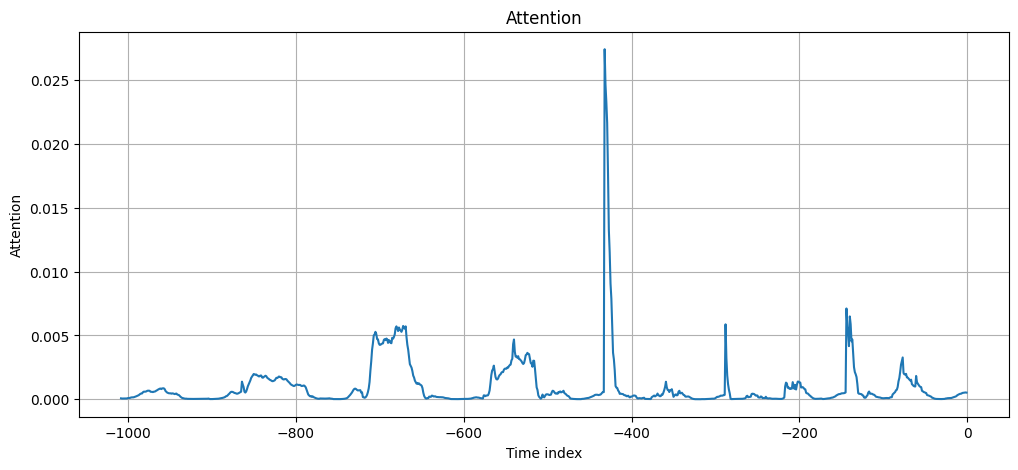

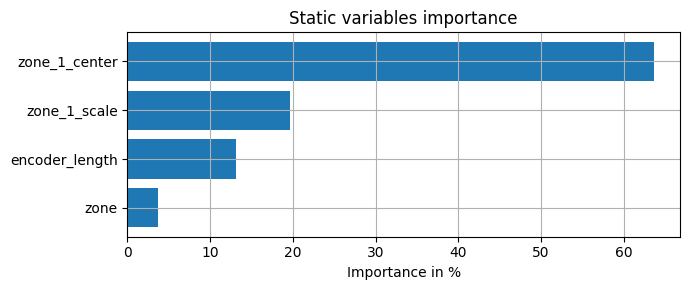

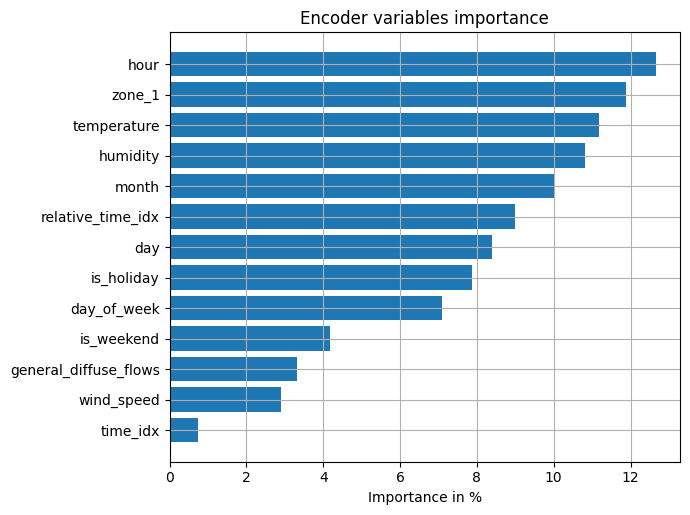

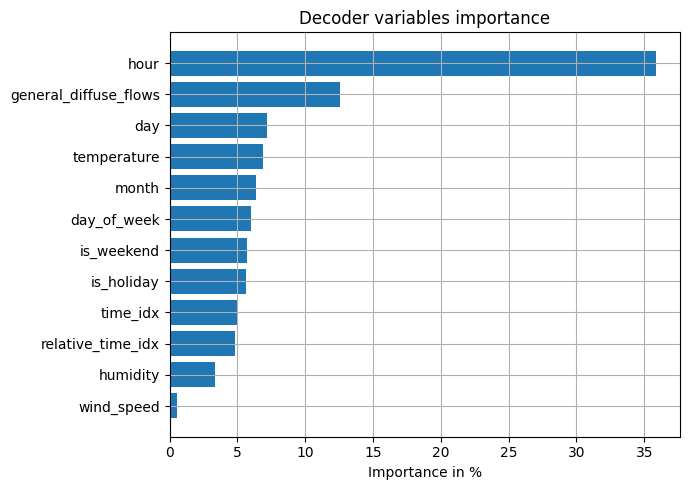

In [ ]:
# 14) Interpretabilidad del TFT

# interpret_output:
#   - Extrae las "importancias" aprendidas por el modelo
#     sobre las variables de entrada y el tiempo.
#   - Permite entender qué variables (ej. temperatura, día de la semana)
#     o qué pasos históricos fueron más influyentes para la predicción.
# reduction="sum":
#   - Suma las contribuciones de importancia a lo largo de todas las muestras,
#     dando una visión global de qué factores dominan el forecast.
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")

# plot_interpretation:
#   - Genera gráficas de las importancias.
#   - Muestra, por ejemplo:
#       • importancia de covariables (qué features climáticas o calendáricas pesan más)
#       • importancia de pasos históricos en el encoder
#       • importancia de las atenciones temporales
figs = tft.plot_interpretation(interpretation)

# Inspección programática:
#   - Recorremos el diccionario devuelto por interpret_output
#   - Mostramos las claves (ej. 'static_variables', 'encoder_variables',
#     'decoder_variables', 'attention') y sus shapes
#   - Esto ayuda a entender qué dimensiones están disponibles para análisis personalizado
for k, v in interpretation.items():
    print(k, getattr(v, "shape", None))

## Interpretación:
El primer gráfico es el gráfico de atención, pero se analizará junto con la serie de tiempo. Pasaremos a analizar los gráficos de importancia de variables tanto en encoder como decoder. En el encoder, la variable más influyente fue **hour**, seguida por zone_1, temperature y humidity, lo que indica que el modelo depende en gran medida del patrón horario y del historial de consumo de energía para aprender la dinámica temporal. En el decoder, destaca nuevamente la variable **hour** y general_diffuse_flows en menor porcentaje, lo que evidencia que la hora del día y las condiciones de radiación difusa influyen significativamente en predicciones futuras. Elmodelo aprende de manera coherente el comportamiento cíciclo diario del consumo energético, considerando además factores meteorológicos y de calendario.

## PRONÓSTICO:

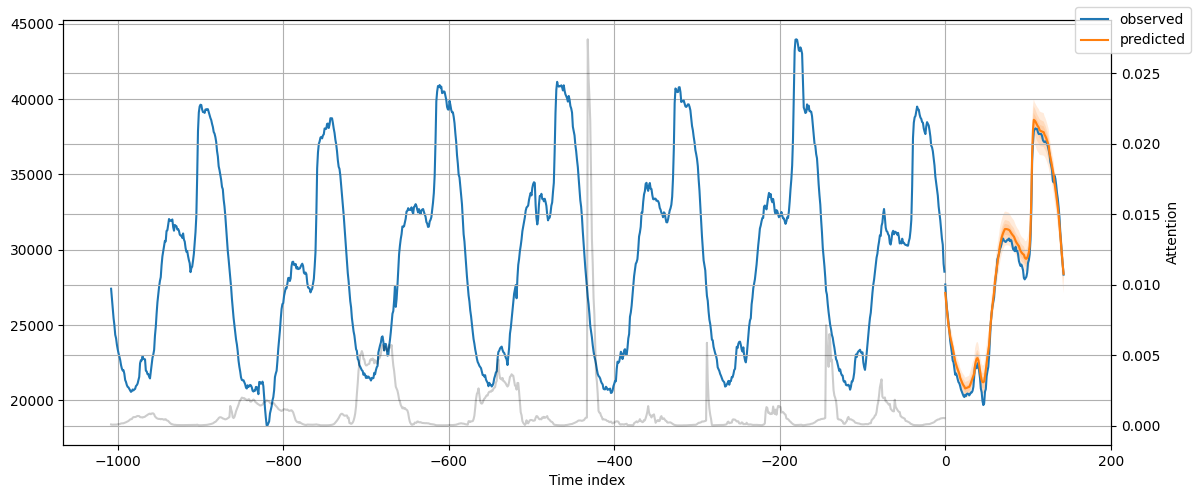

In [ ]:
# 15) Visualización de una predicción individual

# plot_prediction:
#   - Grafica la serie real (target) junto con las predicciones del TFT.
#   - Incluye los cuantiles (p10, p50, p90) si usaste QuantileLoss.
#   - Muestra:
#       • histórico reciente usado por el encoder (izquierda)
#       • horizonte pronosticado por el decoder (derecha)
#   - idx=0 selecciona la primera muestra del DataLoader de validación.
#     Puedes variar idx para inspeccionar otros ejemplos.
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0)

# Renderiza la figura.
plt.show()


## Interpretación:

Este gráfico muestra la serie histórica del consumo de energía (línea azul) junto con las predicciones del modelo TFT (línea naranja) y los valores de atención en el eje derecho (línea del fondo gris). Los picos de atención indican los momentos del pasado que el modelo consideró más relevantes al realizar la predicción. En este caso, se observa que el modelo presta mayor atención a las secciones finales de cada ciclo, lo que sugiere que reconoce patrones estacionales diarios (aquí se muestran 7 días) en la demanda energética. Esto confirma que el modelo no solo captura tendencias globales, sino también la estructura repetitiva del consumo a lo largo del tiempo, aprovechando la información de días anteriores para mejorar el pronóstico.

In [13]:
print("Cuantiles:", quantiles)

Cuantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


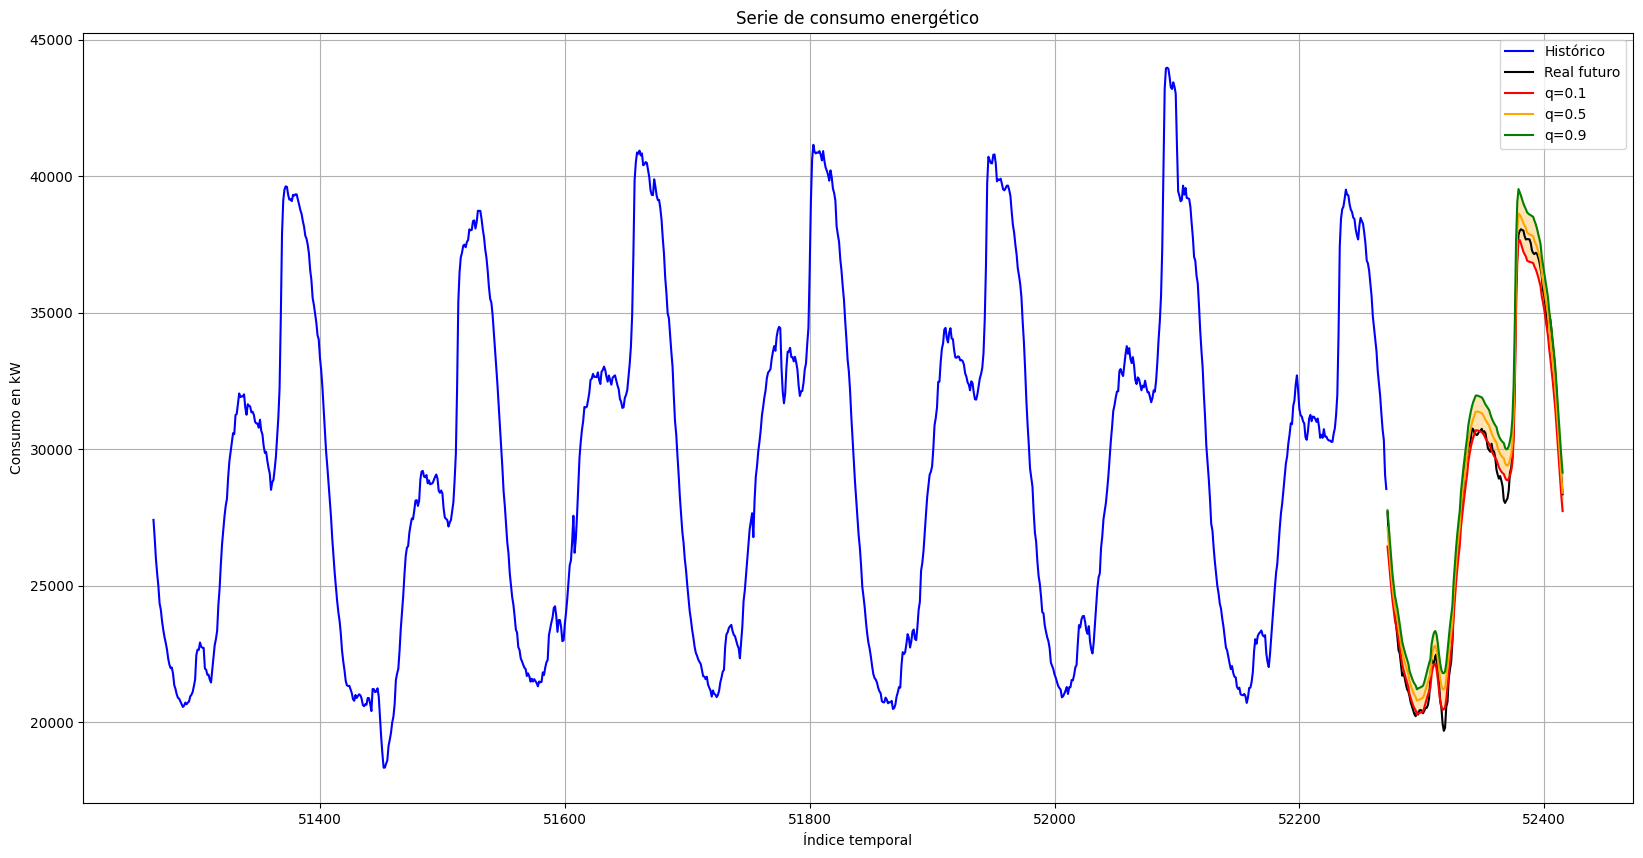

In [ ]:
# 16) Visualización masiva (primer batch de validación)
#     - Muestra histórico (encoder), futuro real (decoder) y cuantiles predichos
#     - Útil para ver consistencia del TFT en distintos casos del mismo lote


# Tomamos el PRIMER batch del val_dataloader para graficar múltiples series
for x_batch, y_batch in val_dataloader:
    x = x_batch
    y = y_batch
    break  # solo el primer batch para inspección

# Número de series (ventanas) en este batch
num_series = len(x["decoder_target"])

for i in range(num_series):  # recorre todas las series del batch
    plt.figure(figsize=(20, 10))

    # 1) Targets real (histórico + futuro)
    # encoder_target: lo que el modelo vio en el pasado (ventana del encoder)
    encoder_target = x["encoder_target"][i].cpu().numpy().flatten()

    # decoder_target: verdad de terreno en el horizonte (lo que queremos predecir)
    decoder_target = x["decoder_target"][i].cpu().numpy().flatten()

    # 2) Eje temporal (time_idx) coherente para cada segmento
    # decoder_time: índices para el futuro inmediato
    decoder_time = x["decoder_time_idx"][i].cpu().numpy().flatten()
    # encoder_time: reconstruimos hacia atrás tantos pasos como tenga el encoder
    encoder_time = np.arange(decoder_time[0] - len(encoder_target), decoder_time[0])

    # 3) Predicciones del TFT (cuantiles)
    preds = raw_predictions.output
    preds = preds[0][i].detach().cpu().numpy()   # -> (prediction_length, n_quantiles)
    preds = np.squeeze(preds)                    # seguridad por si queda (L, Q, 1)

    # 4) Curvas a graficar
    # Histórico (lo visto por el encoder)
    sns.lineplot(x=encoder_time, y=encoder_target, label="Histórico", color="blue")

    # Futuro real (ground truth del decoder)
    sns.lineplot(x=decoder_time, y=decoder_target, label="Real futuro", color="black")

    # Predicciones por cuantiles (ej. 0.1, 0.5, 0.9)
    colores = ["red", "orange", "green"]
    for q, c in zip([0.1, 0.5, 0.9], colores):
        if q in quantiles:
            q_idx = quantiles.index(q)
            sns.lineplot(
                x=decoder_time,
                y=preds[:, q_idx].flatten(),
                label=f"q={q}",
                color=c
            )

    # Banda de incertidumbre p10–p90 (si ambos están disponibles)
    if 0.1 in quantiles and 0.9 in quantiles:
        q10_idx = quantiles.index(0.1)
        q90_idx = quantiles.index(0.9)
        plt.fill_between(
            decoder_time,
            preds[:, q10_idx].flatten(),
            preds[:, q90_idx].flatten(),
            alpha=0.3,
            color="orange"
        )

    # 5) Estética y metadatos
    plt.title("Serie de consumo energético — Zone_1 (Tetuán) | Ventana del batch")
    plt.xlabel("Índice temporal (time_idx a 10 min)")
    plt.ylabel("Consumo (kW)")  # ajusta si tu unidad es distinta
    plt.legend()
    plt.tight_layout()
    plt.show()

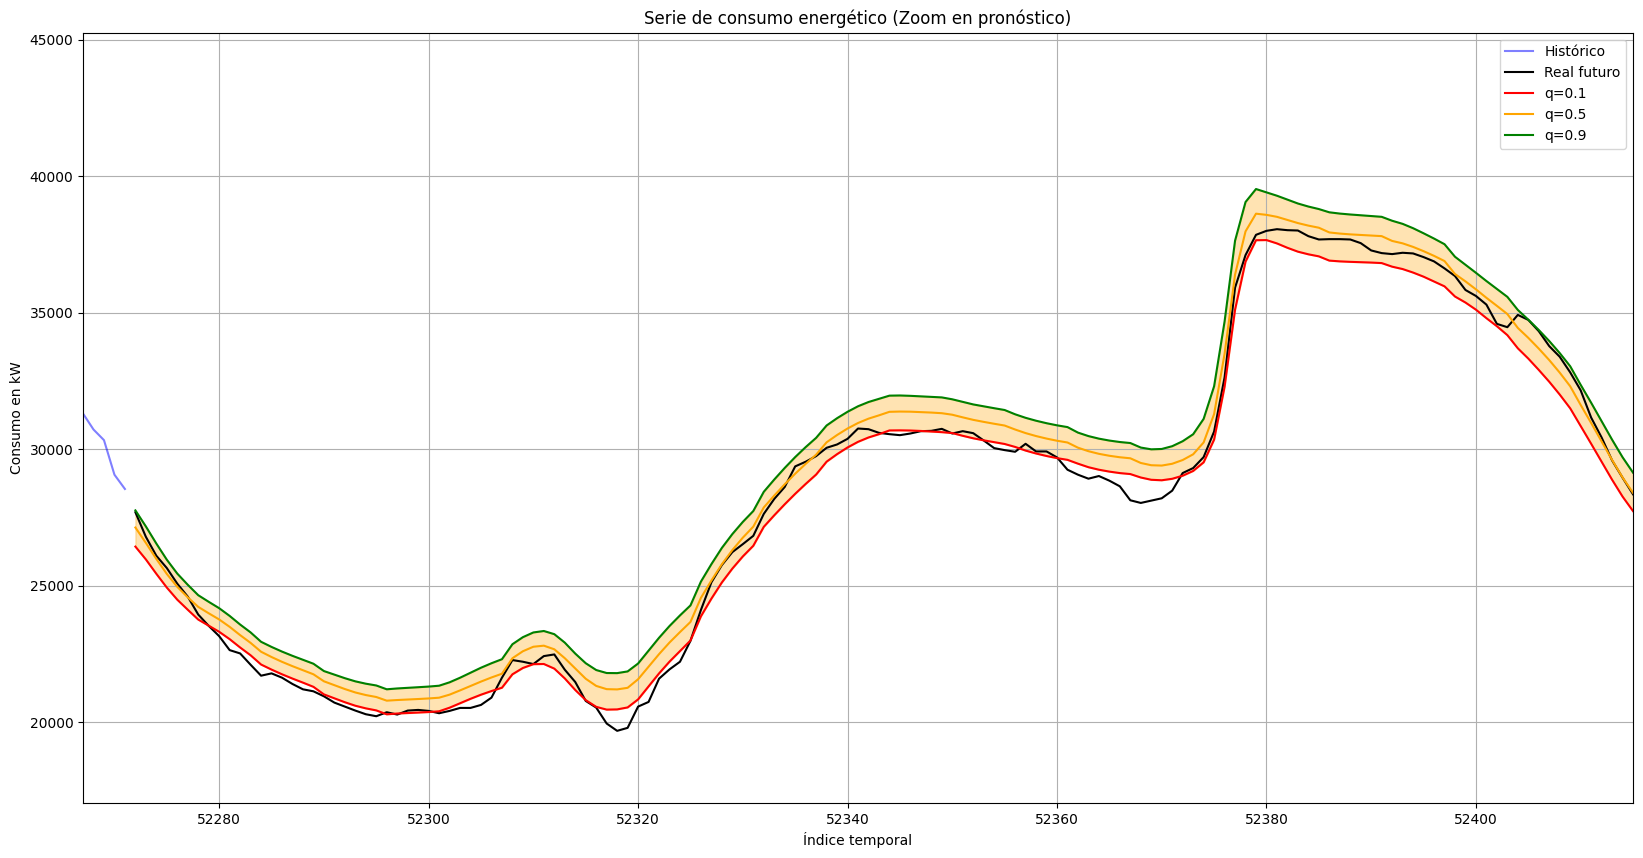

In [ ]:
# 17) Visualización con zoom en el horizonte de predicción

for i in range(num_series):   # recorremos cada serie del batch
    plt.figure(figsize=(20, 10))

    # Histórico (encoder) en azul, con transparencia (alpha=0.5)
    sns.lineplot(x=encoder_time, y=encoder_target, label="Histórico", color="blue", alpha=0.5)

    # Serie real futura (decoder) en negro
    sns.lineplot(x=decoder_time, y=decoder_target, label="Real futuro", color="black")

    # Predicciones por cuantiles: p10, p50 y p90
    colores = ["red", "orange", "green"]
    for q, c in zip([0.1, 0.5, 0.9], colores):
        if q in quantiles:
            q_idx = quantiles.index(q)
            sns.lineplot(x=decoder_time,
                         y=preds[:, q_idx].flatten(),
                         label=f"q={q}", color=c)

    # Banda de incertidumbre (p10–p90) en naranja semitransparente
    if 0.1 in quantiles and 0.9 in quantiles:
        q10_idx = quantiles.index(0.1)
        q90_idx = quantiles.index(0.9)
        plt.fill_between(decoder_time,
                         preds[:, q10_idx].flatten(),
                         preds[:, q90_idx].flatten(),
                         alpha=0.3,
                         color="orange")

    # Ajustes estéticos
    plt.title("Serie de consumo energético (Zoom en pronóstico)")
    plt.xlabel("Índice temporal (time_idx a 10 min)")
    plt.ylabel("Consumo en kW")
    plt.legend()

    # Limitamos el eje X: empezamos un poco antes del forecast
    # (5 pasos antes) y hasta el último índice del decoder.
    plt.xlim(decoder_time[0] - 5, decoder_time[-1])

    plt.show()


In [ ]:
# 18) Inspección puntual en el último instante del forecast

t_final = -1  # índice -1 = último paso de predicción en el horizonte

# Valor real de consumo en ese instante (ground truth del decoder)
valor_real = decoder_target[t_final]

# Valores de los distintos cuantiles predichos por el TFT en ese instante
# (ej: p10, p50, p90). Usamos un dict comprehension para armar un diccionario.
valores_cuantiles = {
    f"p{int(q*100)}": preds[t_final, j]
    for j, q in enumerate(quantiles)
}

print("Ejemplo en el último punto de pronóstico:")
print(f"Valor real: {valor_real:.2f} kW")
for k, v in valores_cuantiles.items():
    print(f"{k}: {v:.2f} kW")

# Convertimos a DataFrame para inspección tabular
# - Incluimos el valor real + los cuantiles predichos
pd.DataFrame([{**{"Valor real": valor_real}, **valores_cuantiles}])

Ejemplo en el último punto de pronóstico:
Valor real: 28349.81 kW
p2: 27109.94 kW
p10: 27734.63 kW
p25: 28076.94 kW
p50: 28404.56 kW
p75: 28735.40 kW
p90: 29142.82 kW
p98: 29690.14 kW


,Valor real,p2,p10,p25,p50,p75,p90,p98
0,28349.810547,27109.935547,27734.628906,28076.939453,28404.560547,28735.402344,29142.816406,29690.140625


## Interpretación de los dos gráficos de cuantiles:

El gráfico de pronóstico muestra las predicciones del modelo TFT a través de tres cuantiles: q=0.1, q=0.5 y q=0.9, que conforman un intervalo de confianza alrededor del valor central (mediana). Las líneas de colores reflejan la incertidumbre asociada al pronóstico, donde el área sombreada entre q=0.1 y q=0.9 representa el rango probable del consumo de energía futuro. Se observa que el modelo sigue adecuadamente la tendencia real (línea negra), incluso en los picos de mayor demanda, lo que indica una buena capacidad de ajuste. Esto muestra que el modelo TFT logra capturar tanto estacionalidad como variaciones repentinas de consumo. Los tres cuantiles resaltados pueden interpretarse, el cuantil del 10% (p10) marca un límite inferior, donde se espera que solo el 10% de los valores reales se ubiquen por debajo de esta línea. El cuantil del 50% (p50) corresponde a la mediana de las predicciones, es decir, el valor central más probable del consumo. Y finalmente, el cuantil del 90% (p90) marca el límite superior, indicando que existe un 90% de probabilidad de que el consumo real se mantenga por debajo de este valor. Teniendo esto en cuenta podemos interpretar un punto del pronóstico y sus valores predichos. Se escogió el último punto del pronóstico (índice -1) y se muestran los siguientes cuantiles:

- p10 = 27,734.63 kW
- p50 = 28,404.56 kW
- p90 = 29,142.82 kW

Esto se traduce en que hay un 90% de confianza en que el consumo real estará por debajo de los 29,142.82 kW y un 10% de confianza en que estará por debajo de 27,734.63 kW. En este punto el valor real observado fue de 28,349.81 kW y la mediana fue de 28,404.56 kW, siendo estos dos valores muy próximos y sugiriendo una alta precisión del modelo.
